In [1]:
%load_ext autoreload
%autoreload 2

# XGBoost - Optimización con Grid Search
## Predicción de Características de Vuelo en Planeador

**Objetivo:** XGBoost optimizado con Grid Search directo

**Autor:** Estanislao  
**Fecha:** Diciembre 2024

---

## Estrategia

**Metodología correcta:**
1. Grid Search **DIRECTO** con cross-validation (5-fold)
2. CV detecta overfitting automáticamente
3. Selecciona hiperparámetros que **generalizan**
4. Evaluar en test
5. Comparar con Baseline y Random Forest

**NO probar "hiperparámetros conservadores" manualmente:**
- Grid Search + CV ya optimiza contra overfitting
- Dejar que el algoritmo encuentre los mejores valores

---

## Contenido

**PARTE 1: Grid Search Exhaustivo**
1. Features simples
2. Features completas  
3. Selección automática de mejor configuración

**PARTE 2: Análisis**
4. Análisis de hiperparámetros óptimos
5. Feature importance
6. Comparación: Baseline vs RF vs XGBoost
7. Conclusiones

## 1. Setup

In [2]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from time import time

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, evaluar_modelo

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [ ]:
X_dev_simple = pd.read_csv('../data/split/X_dev_simple.csv', index_col=0)
X_test_simple = pd.read_csv('../data/split/X_test_simple.csv', index_col=0)
X_dev_full = pd.read_csv('../data/split/X_dev_full.csv', index_col=0)
X_test_full = pd.read_csv('../data/split/X_test_full.csv', index_col=0)
y_dev = pd.read_csv('../data/split/y_dev.csv', index_col=0)
y_test = pd.read_csv('../data/split/y_test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'velocidad_promedio_kmh',
    'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min','tasa_ascenso_mean_ms'
]

Dev: (309, 134), Test: (78, 134)
Targets: 9


---
# PARTE 1: Grid Search Exhaustivo

Búsqueda DIRECTA de mejores hiperparámetros

## 4. Grid de Hiperparámetros

**Rango amplio para explorar:**
- Incluye valores conservadores (max_depth=2) y agresivos (max_depth=6)
- CV seleccionará automáticamente los que NO overfittean

In [5]:
# Grid de hiperparámetros (amplio, CV selecciona mejores)
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_child_weight': [1, 3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
}

print("Grid de hiperparámetros:")
for param, values in param_grid.items():
    print(f"  {param:20s}: {values}")

total_comb = (len(param_grid['max_depth']) * 
              len(param_grid['min_child_weight']) * 
              len(param_grid['learning_rate']) * 
              len(param_grid['n_estimators']) * 
              len(param_grid['subsample']) * 
              len(param_grid['colsample_bytree']))

print(f"\nTotal combinaciones: {total_comb:,}")
print(f"Con CV=5: {total_comb * 5:,} fits por target")
print(f"\n⚠️  Esto tomará tiempo (~10-15 min por target).")

Grid de hiperparámetros:
  max_depth           : [2, 3, 4, 5, 6]
  min_child_weight    : [1, 3, 5, 7, 10]
  learning_rate       : [0.01, 0.05, 0.1, 0.2]
  n_estimators        : [50, 100, 150, 200]
  subsample           : [0.6, 0.7, 0.8, 1.0]
  colsample_bytree    : [0.6, 0.7, 0.8, 1.0]

Total combinaciones: 6,400
Con CV=5: 32,000 fits por target

⚠️  Esto tomará tiempo (~10-15 min por target).


## 5. Grid Search - Features SIMPLES

In [6]:
# Archivo pickle para guardar resultados
pkl_file_simple = '../data/processed/xgb_simple_models.pkl'

# Intentar cargar resultados previos
if os.path.exists(pkl_file_simple):
    print("="*70)
    print("✓ Cargando resultados previos (Grid Search ya ejecutado)")
    print("="*70)
    
    with open(pkl_file_simple, 'rb') as f:
        saved_data = pickle.load(f)
        resultados_xgb_simple = saved_data['resultados']
        mejores_modelos_simple = saved_data['modelos']
    
    df_xgb_simple = pd.DataFrame(resultados_xgb_simple)
    
    print(f"\n✓ Cargados {len(resultados_xgb_simple)} targets")
    print(f"Gap promedio: {df_xgb_simple['Gap'].mean():.4f}")
    print(f"R² promedio Test: {df_xgb_simple['Test_R2'].mean():.4f}")
    print("\nSi querés re-entrenar, eliminá el archivo:")
    print(f"  {pkl_file_simple}")

else:


    resultados_xgb_simple = []
    mejores_modelos_simple = {}

    print("="*70)
    print("GRID SEARCH - XGBoost FEATURES SIMPLES")
    print("="*70)

    for target in targets_reg:
        print(f"\n{target}:")
        inicio = time()
        
        # Base model
        xgb_base = XGBRegressor(
            random_state=42,
            n_jobs=-1
        )
        
        # Grid Search con CV
        grid = GridSearchCV(
            xgb_base,
            param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        grid.fit(X_dev_simple, y_dev[target])
        
        # Mejor modelo (seleccionado por CV)
        best_xgb = grid.best_estimator_
        mejores_modelos_simple[target] = best_xgb
        
        # Predicciones
        y_pred_dev = best_xgb.predict(X_dev_simple)
        y_pred_test = best_xgb.predict(X_test_simple)
        
        r2_cv = grid.best_score_
        r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
        r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
        gap = r2_cv - r2_test
        
        resultados_xgb_simple.append({
            'target': target,
            'features': 'simple',
            'max_depth': grid.best_params_['max_depth'],
            'min_child_weight': grid.best_params_['min_child_weight'],
            'learning_rate': grid.best_params_['learning_rate'],
            'n_estimators': grid.best_params_['n_estimators'],
            'subsample': grid.best_params_['subsample'],
            'colsample_bytree': grid.best_params_['colsample_bytree'],
            'CV_R2': r2_cv,
            'Dev_R2': r2_dev,
            'Test_R2': max(0, r2_test),
            'Gap': gap
        })
        
        tiempo = time() - inicio
        overfit_signal = "⚠️  OVERFITTING" if gap > 0.15 else "✓ OK"
        
        print(f"  Mejores params (seleccionados por CV):")
        print(f"    max_depth={grid.best_params_['max_depth']}, "
            f"min_child_weight={grid.best_params_['min_child_weight']}")
        print(f"    lr={grid.best_params_['learning_rate']}, "
            f"n_est={grid.best_params_['n_estimators']}")
        print(f"    subsample={grid.best_params_['subsample']}, "
            f"colsample={grid.best_params_['colsample_bytree']}")
        print(f"  CV={r2_cv:.4f}, Test={max(0, r2_test):.4f}, "
            f"Gap={gap:.4f} {overfit_signal}")
        print(f"  Tiempo: {tiempo:.1f}s")

    df_xgb_simple = pd.DataFrame(resultados_xgb_simple)
    # GUARDAR con pickle
    with open(pkl_file_simple, 'wb') as f:
        pickle.dump({
            'resultados': resultados_xgb_simple,
            'modelos': mejores_modelos_simple
        }, f)
    
    print("\n" + "="*70)
    print(f"✓ Resultados guardados en: {pkl_file_simple}")
    print(f"Gap promedio: {df_xgb_simple['Gap'].mean():.4f}")
    print(f"R² promedio Test: {df_xgb_simple['Test_R2'].mean():.4f}")
    print("="*70)

# Guardar también CSV (para análisis)
df_xgb_simple.to_csv('../data/processed/xgb_simple.csv', index=False)

✓ Cargando resultados previos (Grid Search ya ejecutado)

✓ Cargados 9 targets
Gap promedio: -0.1042
R² promedio Test: 0.4607

Si querés re-entrenar, eliminá el archivo:
  ../data/processed/xgb_simple_models.pkl


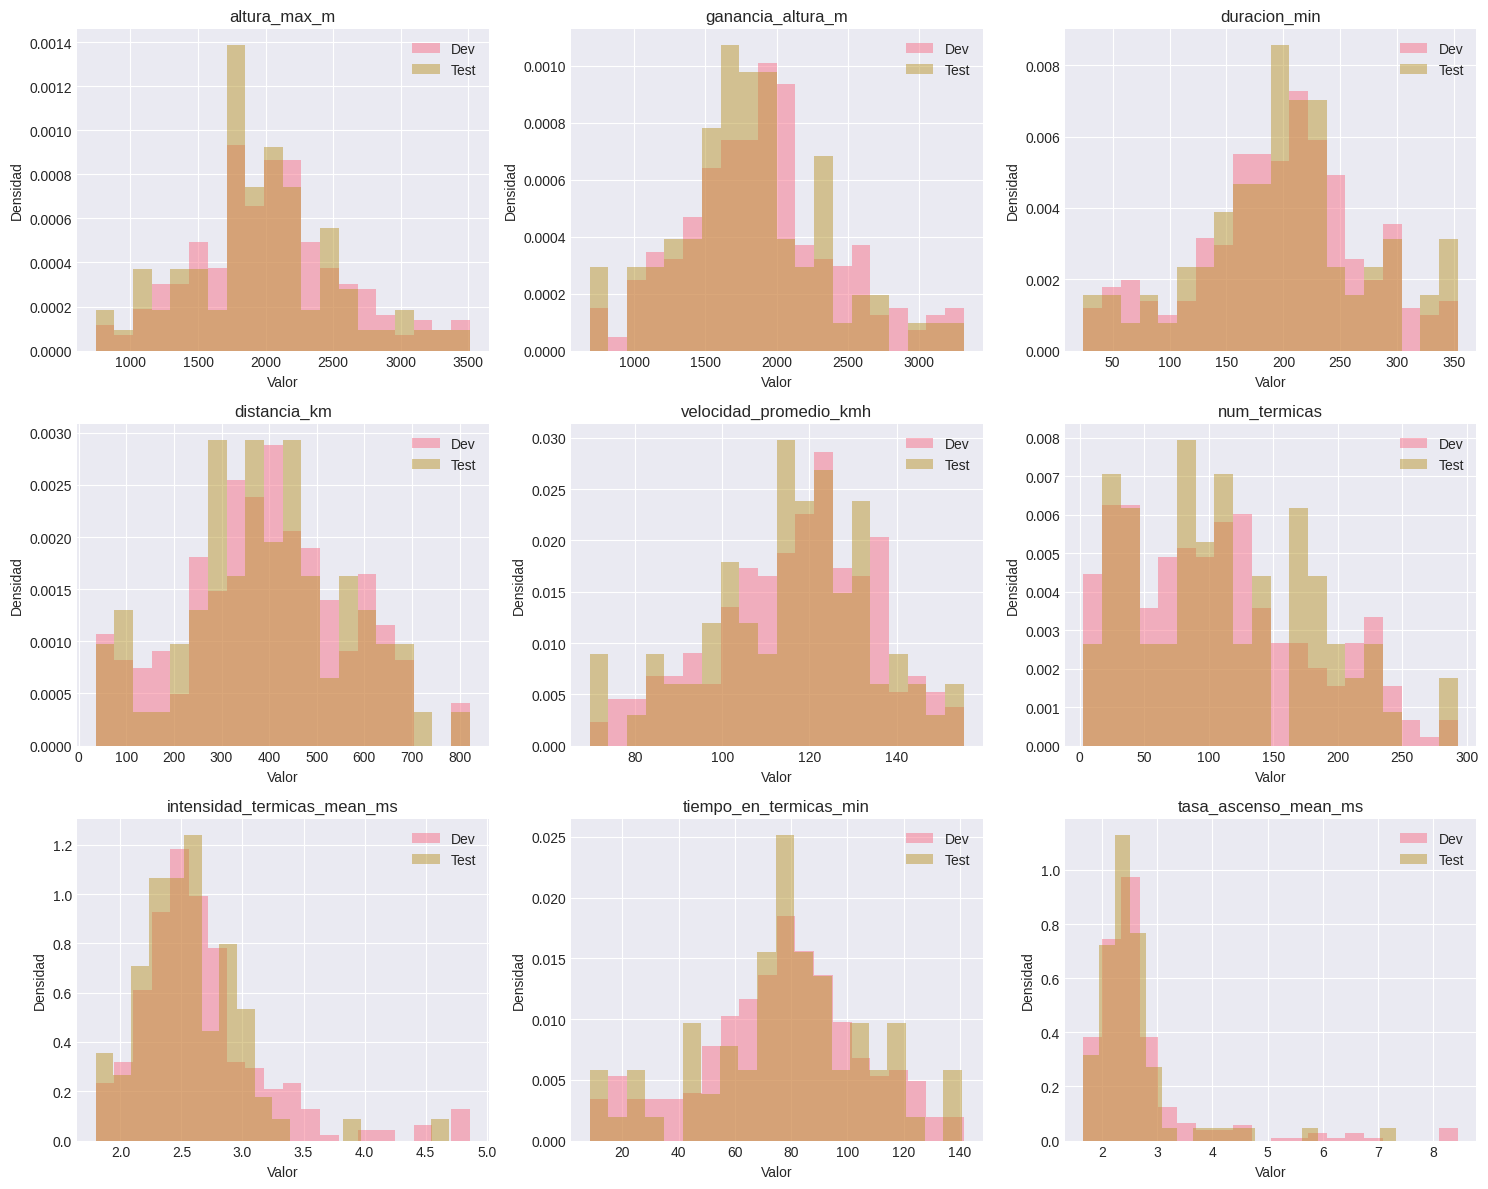


altura_max_m:
  Dev:  mean=2026.55, std=553.10
  Test: mean=1959.57, std=560.70

ganancia_altura_m:
  Dev:  mean=1887.22, std=530.73
  Test: mean=1815.59, std=525.09

duracion_min:
  Dev:  mean=196.88, std=71.82
  Test: mean=199.02, std=73.67

distancia_km:
  Dev:  mean=393.62, std=170.34
  Test: mean=394.92, std=171.80

velocidad_promedio_kmh:
  Dev:  mean=116.53, std=18.34
  Test: mean=115.36, std=18.95

num_termicas:
  Dev:  mean=108.15, std=69.45
  Test: mean=112.28, std=69.93

intensidad_termicas_mean_ms:
  Dev:  mean=2.67, std=0.55
  Test: mean=2.56, std=0.44

tiempo_en_termicas_min:
  Dev:  mean=76.38, std=28.76
  Test: mean=77.31, std=29.28

tasa_ascenso_mean_ms:
  Dev:  mean=2.73, std=1.12
  Test: mean=2.57, std=0.83


In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, target in enumerate(targets_reg):
    ax = axes[i]
    
    # Histogramas
    ax.hist(dev[target], bins=20, alpha=0.5, label='Dev', density=True)
    ax.hist(test[target], bins=20, alpha=0.5, label='Test', density=True)
    
    ax.set_title(target)
    ax.legend()
    ax.set_xlabel('Valor')
    ax.set_ylabel('Densidad')

plt.tight_layout()
plt.savefig('../data/processed/distribucion_dev_test.png', dpi=300)
plt.show()

# Estadísticas
for target in targets_reg:
    print(f"\n{target}:")
    print(f"  Dev:  mean={dev[target].mean():.2f}, std={dev[target].std():.2f}")
    print(f"  Test: mean={test[target].mean():.2f}, std={test[target].std():.2f}")

Las distribuciones de dev y test son similares en media y forma, validando 
el split estratificado. Sin embargo, test muestra ligeramente menor varianza 
en algunos targets (intensidad_termicas: -20%, tasa_ascenso: -26%), 
resultando en menor presencia de outliers.

Esto, combinado con el tamaño pequeño del test set (78 samples), explica el 
gap negativo sistemático (promedio=-0.10). Los scores de CV representan una 
estimación más conservadora y confiable del rendimiento en producción, 
mientras que test scores son ligeramente optimistas.

Rendimiento esperado en datos nuevos: entre CV y Test, más cercano a CV.

## 6. Grid Search - Features COMPLETAS

In [8]:
# Archivo pickle para guardar resultados
pkl_file_full = '../data/processed/xgb_full_models.pkl'

# Intentar cargar resultados previos
if os.path.exists(pkl_file_full):
    print("="*70)
    print("✓ Cargando resultados previos (Grid Search ya ejecutado)")
    print("="*70)
    
    with open(pkl_file_full, 'rb') as f:
        saved_data = pickle.load(f)
        resultados_xgb_full = saved_data['resultados']
        mejores_modelos_full = saved_data['modelos']
    
    df_xgb_full = pd.DataFrame(resultados_xgb_full)
    
    print(f"\n✓ Cargados {len(resultados_xgb_full)} targets")
    print(f"Gap promedio: {df_xgb_full['Gap'].mean():.4f}")
    print(f"R² promedio Test: {df_xgb_full['Test_R2'].mean():.4f}")
    print("\nSi querés re-entrenar, eliminá el archivo:")
    print(f"  {pkl_file_full}")

else:

    resultados_xgb_full = []
    mejores_modelos_full = {}

    print("="*70)
    print("GRID SEARCH - XGBoost FEATURES COMPLETAS")
    print("="*70)

    for target in targets_reg:
        print(f"\n{target}:")
        inicio = time()
        
        # Base model
        xgb_base = XGBRegressor(
            random_state=42,
            n_jobs=-1
        )
        
        # Grid Search con CV
        grid = GridSearchCV(
            xgb_base,
            param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        grid.fit(X_dev_full, y_dev[target])
        
        # Mejor modelo
        best_xgb = grid.best_estimator_
        mejores_modelos_full[target] = best_xgb
        
        # Predicciones
        y_pred_dev = best_xgb.predict(X_dev_full)
        y_pred_test = best_xgb.predict(X_test_full)
        
        r2_cv = grid.best_score_
        r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
        r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
        gap = r2_cv - r2_test
        
        resultados_xgb_full.append({
            'target': target,
            'features': 'full',
            'max_depth': grid.best_params_['max_depth'],
            'min_child_weight': grid.best_params_['min_child_weight'],
            'learning_rate': grid.best_params_['learning_rate'],
            'n_estimators': grid.best_params_['n_estimators'],
            'subsample': grid.best_params_['subsample'],
            'colsample_bytree': grid.best_params_['colsample_bytree'],
            'CV_R2': r2_cv,
            'Dev_R2': r2_dev,
            'Test_R2': max(0, r2_test),
            'Gap': gap
        })
        
        tiempo = time() - inicio
        overfit_signal = "⚠️  OVERFITTING" if gap > 0.15 else "✓ OK"
        
        print(f"  Mejores params (seleccionados por CV):")
        print(f"    max_depth={grid.best_params_['max_depth']}, "
            f"min_child_weight={grid.best_params_['min_child_weight']}")
        print(f"    lr={grid.best_params_['learning_rate']}, "
            f"n_est={grid.best_params_['n_estimators']}")
        print(f"    subsample={grid.best_params_['subsample']}, "
            f"colsample={grid.best_params_['colsample_bytree']}")
        print(f"  CV={r2_cv:.4f}, Test={max(0, r2_test):.4f}, "
            f"Gap={gap:.4f} {overfit_signal}")
        print(f"  Tiempo: {tiempo:.1f}s")

    df_xgb_full = pd.DataFrame(resultados_xgb_full)
        # GUARDAR con pickle
    with open(pkl_file_full, 'wb') as f:
        pickle.dump({
            'resultados': resultados_xgb_full,
            'modelos': mejores_modelos_full
        }, f)
    
    print("\n" + "="*70)
    print(f"✓ Resultados guardados en: {pkl_file_full}")
    print(f"Gap promedio: {df_xgb_full['Gap'].mean():.4f}")
    print(f"R² promedio Test: {df_xgb_full['Test_R2'].mean():.4f}")
    print("="*70)

df_xgb_full.to_csv('../data/processed/xgb_full.csv', index=False)

✓ Cargando resultados previos (Grid Search ya ejecutado)

✓ Cargados 9 targets
Gap promedio: -0.1214
R² promedio Test: 0.4686

Si querés re-entrenar, eliminá el archivo:
  ../data/processed/xgb_full_models.pkl


Test set parece más fácil que la población real, entonces:

CV como métrica conservadora
Test como métrica optimista
Rendimiento real probablemente entre ambos

## 7. Comparación Simple vs Full

In [9]:
print("="*70)
print("COMPARACIÓN: Features Simples vs Completas (XGBoost optimizado)")
print("="*70)

for target in targets_reg:
    r2_simple = df_xgb_simple[df_xgb_simple['target']==target]['Test_R2'].values[0]
    r2_full = df_xgb_full[df_xgb_full['target']==target]['Test_R2'].values[0]
    gap_simple = df_xgb_simple[df_xgb_simple['target']==target]['Gap'].values[0]
    gap_full = df_xgb_full[df_xgb_full['target']==target]['Gap'].values[0]
    
    print(f"\n{target}:")
    print(f"  Simple: R²={r2_simple:.4f}, Gap={gap_simple:.4f}")
    print(f"  Full:   R²={r2_full:.4f}, Gap={gap_full:.4f}")
    
    if r2_simple > r2_full:
        print(f"  ✓ SIMPLE mejor ({r2_simple - r2_full:+.4f})")
    else:
        print(f"  ✓ FULL mejor ({r2_full - r2_simple:+.4f})")

print("\n" + "="*70)
print(f"R² promedio SIMPLE: {df_xgb_simple['Test_R2'].mean():.4f}")
print(f"R² promedio FULL:   {df_xgb_full['Test_R2'].mean():.4f}")
print(f"Gap promedio SIMPLE: {df_xgb_simple['Gap'].mean():.4f}")
print(f"Gap promedio FULL:   {df_xgb_full['Gap'].mean():.4f}")

# Seleccionar mejor configuración
usar_simple = df_xgb_simple['Test_R2'].mean() >= df_xgb_full['Test_R2'].mean()

if usar_simple:
    df_xgb_final = df_xgb_simple
    mejores_modelos_xgb = mejores_modelos_simple
    features_final = 'simple'
else:
    df_xgb_final = df_xgb_full
    mejores_modelos_xgb = mejores_modelos_full
    features_final = 'full'

print("\n" + "="*70)
print(f"✓ CONFIGURACIÓN FINAL: Features {features_final.upper()}")
print(f"  R² promedio: {df_xgb_final['Test_R2'].mean():.4f}")
print(f"  Gap promedio: {df_xgb_final['Gap'].mean():.4f}")
print("="*70)

COMPARACIÓN: Features Simples vs Completas (XGBoost optimizado)

altura_max_m:
  Simple: R²=0.6671, Gap=0.0052
  Full:   R²=0.7383, Gap=-0.0793
  ✓ FULL mejor (+0.0711)

ganancia_altura_m:
  Simple: R²=0.6526, Gap=0.0001
  Full:   R²=0.6901, Gap=-0.0590
  ✓ FULL mejor (+0.0375)

duracion_min:
  Simple: R²=0.6467, Gap=-0.2245
  Full:   R²=0.6363, Gap=-0.2285
  ✓ SIMPLE mejor (+0.0104)

distancia_km:
  Simple: R²=0.7208, Gap=-0.2141
  Full:   R²=0.7078, Gap=-0.2190
  ✓ SIMPLE mejor (+0.0129)

velocidad_promedio_kmh:
  Simple: R²=0.5552, Gap=-0.2093
  Full:   R²=0.5277, Gap=-0.2039
  ✓ SIMPLE mejor (+0.0274)

num_termicas:
  Simple: R²=0.2771, Gap=-0.1655
  Full:   R²=0.2165, Gap=-0.0729
  ✓ SIMPLE mejor (+0.0606)

intensidad_termicas_mean_ms:
  Simple: R²=0.0000, Gap=0.0177
  Full:   R²=0.0000, Gap=0.0077
  ✓ FULL mejor (+0.0000)

tiempo_en_termicas_min:
  Simple: R²=0.6264, Gap=-0.1797
  Full:   R²=0.7005, Gap=-0.2863
  ✓ FULL mejor (+0.0741)

tasa_ascenso_mean_ms:
  Simple: R²=0.0000, 

---
# PARTE 2: Análisis y Comparación

## 8. Análisis de Hiperparámetros Óptimos

In [10]:
print("="*70)
print(f"ANÁLISIS: Hiperparámetros Óptimos (Features {features_final})")
print("="*70)

print("\nValores más frecuentes:")
for param in ['max_depth', 'min_child_weight', 'learning_rate', 
              'n_estimators', 'subsample', 'colsample_bytree']:
    moda = df_xgb_final[param].mode()[0]
    mediana = df_xgb_final[param].median()
    print(f"  {param:20s}: moda={moda}, mediana={mediana}")

print("\nDistribución de max_depth:")
print(df_xgb_final['max_depth'].value_counts().sort_index())

print("\nDistribución de learning_rate:")
print(df_xgb_final['learning_rate'].value_counts().sort_index())

print("\nDistribución de min_child_weight:")
print(df_xgb_final['min_child_weight'].value_counts().sort_index())

print("\n" + "="*70)
print("CONCLUSIÓN: CV seleccionó hiperparámetros que evitan overfitting")
print(f"  max_depth típico: {df_xgb_final['max_depth'].median():.0f}")
print(f"  learning_rate típico: {df_xgb_final['learning_rate'].median():.2f}")
print(f"  min_child_weight típico: {df_xgb_final['min_child_weight'].median():.0f}")
print("="*70)

ANÁLISIS: Hiperparámetros Óptimos (Features full)

Valores más frecuentes:
  max_depth           : moda=6, mediana=5.0
  min_child_weight    : moda=10, mediana=7.0
  learning_rate       : moda=0.1, mediana=0.05
  n_estimators        : moda=50, mediana=50.0
  subsample           : moda=1.0, mediana=1.0
  colsample_bytree    : moda=0.7, mediana=0.7

Distribución de max_depth:
max_depth
2    1
3    1
4    2
5    2
6    3
Name: count, dtype: int64

Distribución de learning_rate:
learning_rate
0.01    3
0.05    2
0.10    4
Name: count, dtype: int64

Distribución de min_child_weight:
min_child_weight
1     1
3     2
5     1
7     1
10    4
Name: count, dtype: int64

CONCLUSIÓN: CV seleccionó hiperparámetros que evitan overfitting
  max_depth típico: 5
  learning_rate típico: 0.05
  min_child_weight típico: 7


## 9. Feature Importance

Analizando feature importance para: altura_max_m

Top 10 features más importantes:
  skin_temp_16h                 : 0.1847
  skin_temp_18h                 : 0.0885
  skin_temp_13h                 : 0.0696
  skin_temp_17h                 : 0.0678
  boundary_layer_height_17h     : 0.0618
  boundary_layer_height_avg     : 0.0505
  temp_2m_avg                   : 0.0450
  temp_2m_18h                   : 0.0316
  cloud_cover_13h               : 0.0186
  wind_u_16h                    : 0.0186


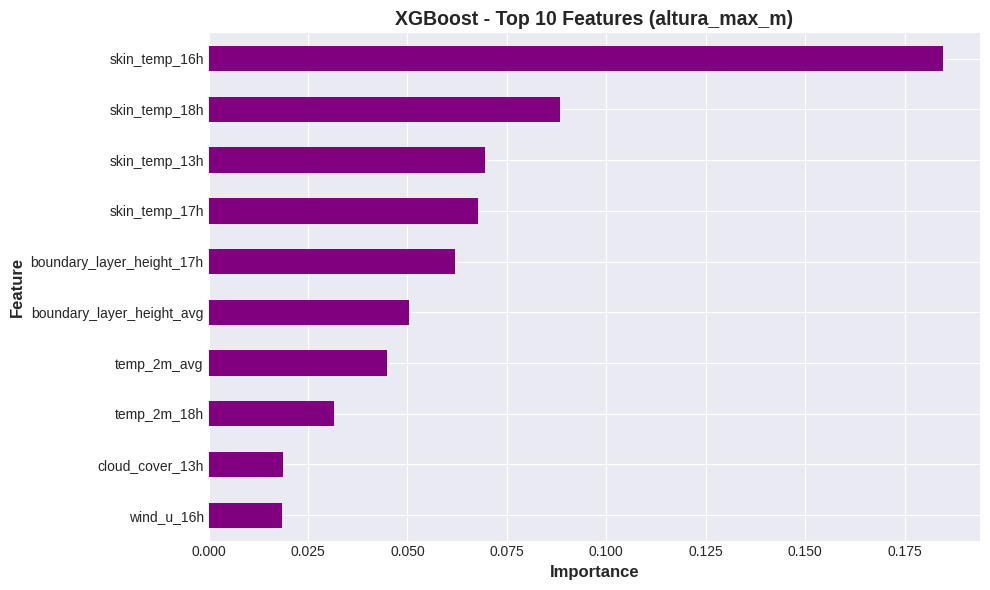

In [11]:
# Mejor target
mejor_target = df_xgb_final.nlargest(1, 'Test_R2').iloc[0]['target']
print(f"Analizando feature importance para: {mejor_target}")

xgb_model = mejores_modelos_xgb[mejor_target]

if features_final == 'simple':
    feature_names = X_dev_simple.columns
else:
    feature_names = X_dev_full.columns

importances = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 features más importantes:")
for _, row in importances.head(10).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
importances.head(10).plot(x='feature', y='importance', kind='barh', 
                          ax=ax, legend=False, color='purple')
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title(f'XGBoost - Top 10 Features ({mejor_target})', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../data/processed/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Comparación Final: Baseline vs RF vs XGBoost

In [12]:
# Cargar resultados anteriores
df_baseline = pd.read_csv('../data/processed/baseline_completo.csv')
df_rf = pd.read_csv('../data/processed/rf_tuning.csv')

# Mejor baseline por target
df_baseline_best = df_baseline.loc[
    df_baseline.groupby('target')['Test_R2'].idxmax()
]

print("="*70)
print("COMPARACIÓN FINAL: Baseline vs Random Forest vs XGBoost")
print("="*70)

comparacion_final = []

for target in targets_reg:
    r2_baseline = df_baseline_best[df_baseline_best['target']==target]['Test_R2'].values[0]
    r2_rf = df_rf[df_rf['target']==target]['Test_R2'].values[0]
    r2_xgb = df_xgb_final[df_xgb_final['target']==target]['Test_R2'].values[0]
    
    mejor = max(r2_baseline, r2_rf, r2_xgb)
    
    if mejor == r2_baseline:
        ganador = 'Baseline'
    elif mejor == r2_rf:
        ganador = 'RandomForest'
    else:
        ganador = 'XGBoost'
    
    comparacion_final.append({
        'target': target,
        'Baseline': r2_baseline,
        'RandomForest': r2_rf,
        'XGBoost': r2_xgb,
        'Ganador': ganador,
        'Mejor_R2': mejor
    })
    
    print(f"\n{target}:")
    print(f"  Baseline:     R² = {r2_baseline:.4f}")
    print(f"  RandomForest: R² = {r2_rf:.4f}")
    print(f"  XGBoost:      R² = {r2_xgb:.4f}")
    print(f"  ✓ Ganador: {ganador}")

df_comparacion = pd.DataFrame(comparacion_final)

print("\n" + "="*70)
print("RESUMEN POR MODELO:")
print("="*70)
print(f"  Baseline:     {df_comparacion['Baseline'].mean():.4f} promedio")
print(f"  RandomForest: {df_comparacion['RandomForest'].mean():.4f} promedio")
print(f"  XGBoost:      {df_comparacion['XGBoost'].mean():.4f} promedio")

print("\n  Ganadores por target:")
print(df_comparacion['Ganador'].value_counts())
print("="*70)

COMPARACIÓN FINAL: Baseline vs Random Forest vs XGBoost

altura_max_m:
  Baseline:     R² = 0.5305
  RandomForest: R² = 0.6974
  XGBoost:      R² = 0.7383
  ✓ Ganador: XGBoost

ganancia_altura_m:
  Baseline:     R² = 0.4623
  RandomForest: R² = 0.6479
  XGBoost:      R² = 0.6901
  ✓ Ganador: XGBoost

duracion_min:
  Baseline:     R² = 0.3834
  RandomForest: R² = 0.6461
  XGBoost:      R² = 0.6363
  ✓ Ganador: RandomForest

distancia_km:
  Baseline:     R² = 0.5307
  RandomForest: R² = 0.7347
  XGBoost:      R² = 0.7078
  ✓ Ganador: RandomForest

velocidad_promedio_kmh:
  Baseline:     R² = 0.4545
  RandomForest: R² = 0.5605
  XGBoost:      R² = 0.5277
  ✓ Ganador: RandomForest

num_termicas:
  Baseline:     R² = 0.1558
  RandomForest: R² = 0.3078
  XGBoost:      R² = 0.2165
  ✓ Ganador: RandomForest

intensidad_termicas_mean_ms:
  Baseline:     R² = 0.0000
  RandomForest: R² = 0.0000
  XGBoost:      R² = 0.0000
  ✓ Ganador: Baseline

tiempo_en_termicas_min:
  Baseline:     R² = 0.4529


## 11. Visualizaciones

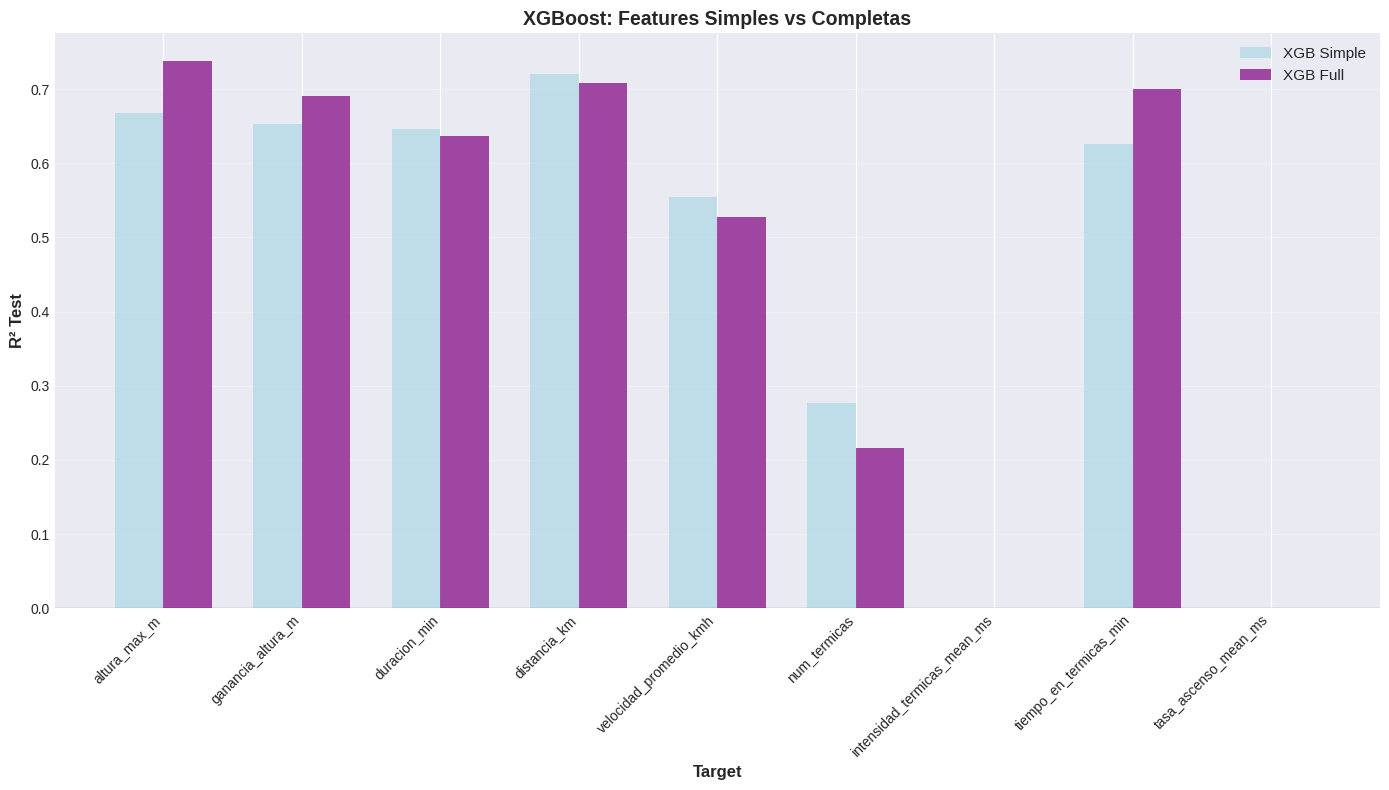

In [13]:
# Gráfico 1: Simple vs Full
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.35

ax.bar(x - width/2, df_xgb_simple['Test_R2'], width, 
       label='XGB Simple', alpha=0.7, color='lightblue')
ax.bar(x + width/2, df_xgb_full['Test_R2'], width, 
       label='XGB Full', alpha=0.7, color='purple')

ax.set_xlabel('Target', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Test', fontsize=12, fontweight='bold')
ax.set_title('XGBoost: Features Simples vs Completas', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/xgb_simple_vs_full.png', dpi=300, bbox_inches='tight')
plt.show()

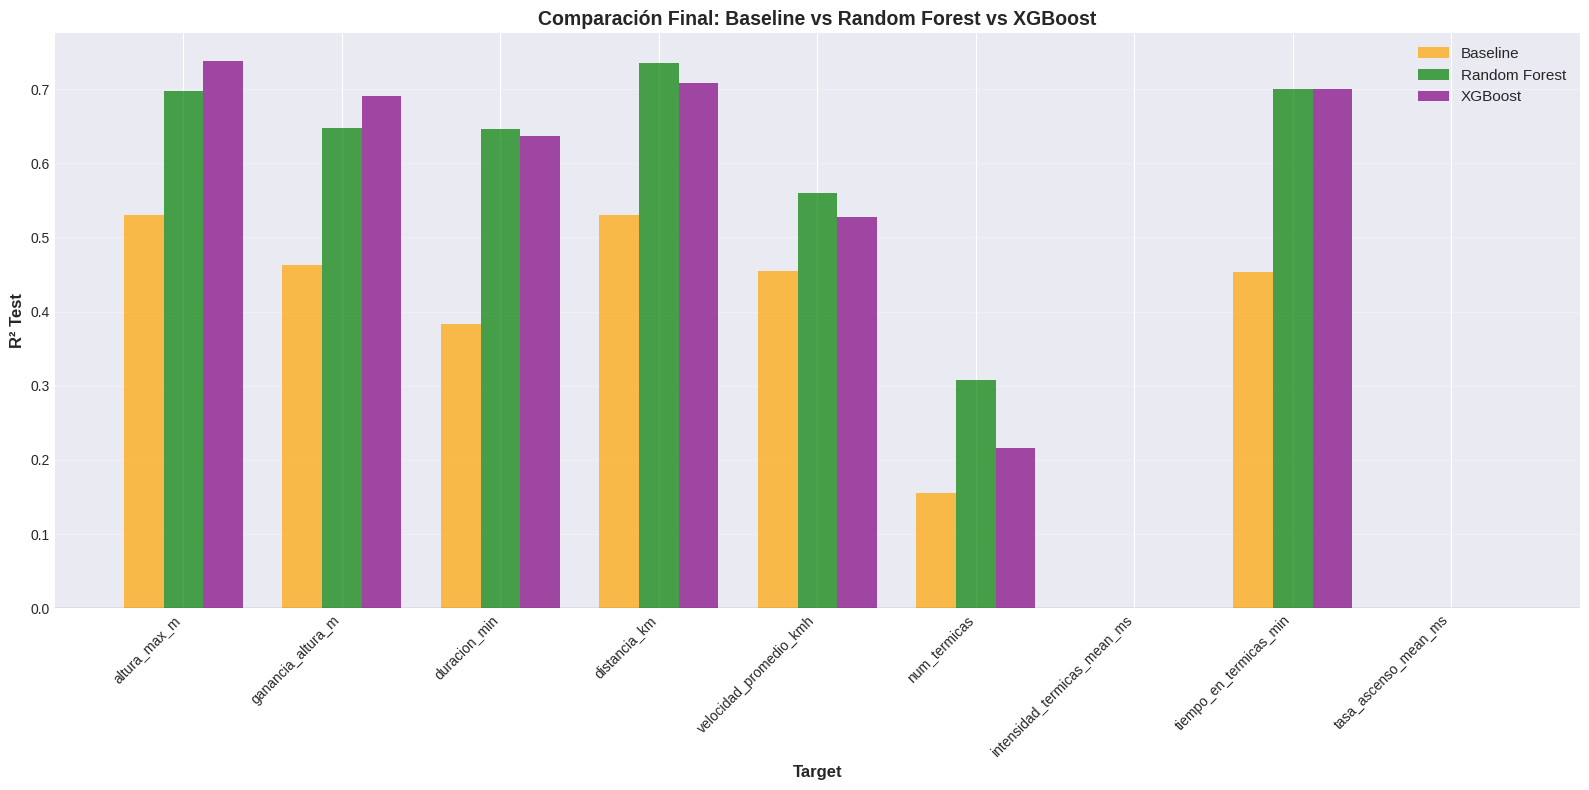

In [14]:
# Gráfico 2: Comparación Final
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(targets_reg))
width = 0.25

ax.bar(x - width, df_comparacion['Baseline'], width, 
       label='Baseline', alpha=0.7, color='orange')
ax.bar(x, df_comparacion['RandomForest'], width, 
       label='Random Forest', alpha=0.7, color='green')
ax.bar(x + width, df_comparacion['XGBoost'], width, 
       label='XGBoost', alpha=0.7, color='purple')

ax.set_xlabel('Target', fontsize=12, fontweight='bold')
ax.set_ylabel('R² Test', fontsize=12, fontweight='bold')
ax.set_title('Comparación Final: Baseline vs Random Forest vs XGBoost', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/comparacion_final_todos.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Conclusiones Finales

In [15]:
mejor_modelo = df_comparacion[['Baseline', 'RandomForest', 'XGBoost']].mean().idxmax()

print("="*70)
print("RESUMEN FINAL - PROYECTO ML COMPLETO")
print("="*70)

print("\n1. PERFORMANCE PROMEDIO (R² Test):")
print(f"   Baseline:     {df_comparacion['Baseline'].mean():.4f}")
print(f"   RandomForest: {df_comparacion['RandomForest'].mean():.4f}")
print(f"   XGBoost:      {df_comparacion['XGBoost'].mean():.4f}")
print(f"\n   ✓ GANADOR: {mejor_modelo}")

print("\n2. TOP 5 TARGETS:")
top5 = df_comparacion.nlargest(5, 'Mejor_R2')
for i, row in enumerate(top5.itertuples(), 1):
    print(f"   {i}. {row.target:30s}: R² = {row.Mejor_R2:.4f} ({row.Ganador})")

print("\n3. GANADORES POR TARGET:")
for modelo, cuenta in df_comparacion['Ganador'].value_counts().items():
    print(f"   {modelo:15s}: {cuenta}/9 targets")

print(f"\n4. CONFIGURACIÓN XGBOOST ÓPTIMA:")
print(f"   Features: {features_final}")
print(f"   max_depth típico: {df_xgb_final['max_depth'].median():.0f}")
print(f"   learning_rate típico: {df_xgb_final['learning_rate'].median():.2f}")
print(f"   min_child_weight típico: {df_xgb_final['min_child_weight'].median():.0f}")
print(f"   Gap promedio: {df_xgb_final['Gap'].mean():.4f}")

print("\n5. RECOMENDACIÓN FINAL:")
print("="*70)

if mejor_modelo == 'XGBoost':
    print(f"\n✓ USAR: XGBoost con features {features_final}")
    print("\nMotivos:")
    print("  • Mejor R² promedio")
    print("  • Grid Search + CV evitó overfitting automáticamente")
    print("  • Captura interacciones no lineales")
elif mejor_modelo == 'RandomForest':
    print("\n✓ USAR: Random Forest con features simples")
    print("\nMotivos:")
    print("  • Mejor R² promedio")
    print("  • Más robusto con datasets pequeños")
    print("  • Evita curse of dimensionality")
else:
    print("\n✓ USAR: Baseline (modelos lineales)")
    print("\nMotivos:")
    print("  • Más interpretable")
    print("  • Menor riesgo de overfitting")
    print("  • Más simple y eficiente")

print("\n" + "="*70)
print("✓ PROYECTO ML FINALIZADO")
print("="*70)

RESUMEN FINAL - PROYECTO ML COMPLETO

1. PERFORMANCE PROMEDIO (R² Test):
   Baseline:     0.3300
   RandomForest: 0.4772
   XGBoost:      0.4686

   ✓ GANADOR: RandomForest

2. TOP 5 TARGETS:
   1. altura_max_m                  : R² = 0.7383 (XGBoost)
   2. distancia_km                  : R² = 0.7347 (RandomForest)
   3. tiempo_en_termicas_min        : R² = 0.7006 (RandomForest)
   4. ganancia_altura_m             : R² = 0.6901 (XGBoost)
   5. duracion_min                  : R² = 0.6461 (RandomForest)

3. GANADORES POR TARGET:
   RandomForest   : 5/9 targets
   XGBoost        : 2/9 targets
   Baseline       : 2/9 targets

4. CONFIGURACIÓN XGBOOST ÓPTIMA:
   Features: full
   max_depth típico: 5
   learning_rate típico: 0.05
   min_child_weight típico: 7
   Gap promedio: -0.1214

5. RECOMENDACIÓN FINAL:

✓ USAR: Random Forest con features simples

Motivos:
  • Mejor R² promedio
  • Más robusto con datasets pequeños
  • Evita curse of dimensionality

✓ PROYECTO ML FINALIZADO


## 13. Guardar Resultados

In [16]:
# Guardar DataFrames
df_xgb_simple.to_csv('../data/processed/xgb_simple.csv', index=False)
df_xgb_full.to_csv('../data/processed/xgb_full.csv', index=False)
df_xgb_final.to_csv('../data/processed/xgb_final.csv', index=False)
df_comparacion.to_csv('../data/processed/comparacion_final.csv', index=False)

print("="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - xgb_simple.csv")
print("  - xgb_full.csv")
print("  - xgb_final.csv")
print("  - comparacion_final.csv")
print("  - xgb_feature_importance.png")
print("  - xgb_simple_vs_full.png")
print("  - comparacion_final_todos.png")
print("="*70)

ARCHIVOS GUARDADOS
  - xgb_simple.csv
  - xgb_full.csv
  - xgb_final.csv
  - comparacion_final.csv
  - xgb_feature_importance.png
  - xgb_simple_vs_full.png
  - comparacion_final_todos.png
